This is file runs the main calculation for the flexible length TPS simulation. It requires the file `alanine_dipeptide_tps_equil.nc`, which is written in the notebook `alanine_dipeptide_tps_first_traj.ipynb`.

In this file, you will learn:
* how to set up and run a flexible length TPS simulation

NB: This is a long calculation. In practice, it would be best to export the Python from this notebook, remove the `live_visualization`, and run non-interactively on a computing node.

In [1]:
%matplotlib inline
import openpathsampling as paths

## Load engine, trajectory, and states from file

In [2]:
old_storage = paths.Storage("tps_nc_files/alanine_dipeptide_tps_equil.nc", "r")

In [3]:
engine = old_storage.engines[0]
C_7eq = old_storage.volumes.find('C_7eq')
alpha_R = old_storage.volumes.find('alpha_R')
traj = old_storage.samplesets[len(old_storage.samplesets)-1][0].trajectory
phi = old_storage.cvs.find('phi')
psi = old_storage.cvs.find('psi')
template = old_storage.snapshots[0]

In [4]:
print engine.name

300K


## TPS

As always, the process for setting up a simulation is:

1. Create a `network`
2. Create a `move_scheme`
3. Set up `initial_conditions`
4. Create the `PathSampling` object and run it.

Since we already created all the input to these when we set up the first trajectory, we can load use the versions we loaded above.

In [5]:
network = paths.TPSNetwork(C_7eq, alpha_R)

In [6]:
scheme = paths.OneWayShootingMoveScheme(network, selector=paths.UniformSelector(), engine=engine)

In [7]:
initial_conditions = scheme.initial_conditions_from_trajectories(traj)

# finished generating: still missing 0 samples
1


In [8]:
storage = paths.Storage("tps_nc_files/alanine_dipeptide_tps.nc", "w", template)
sampler = paths.PathSampling(storage=storage,
                             move_scheme=scheme,
                             sample_set=initial_conditions).named("Flexible_TPS_Sampling")

Note: 10000 steps will take a long time. If you just want to run a little bit, reduce this number.

In [9]:
#sampler.live_visualization = paths.LiveVisualization(network, phi, psi, [-3.14, 3.14], [-3.14, 3.14])
sampler.run(10000)

Working on Monte Carlo cycle number 10000
Running for 13550 seconds -  0.74 steps per second
Expected time to finish: 1 seconds
DONE! Completed 10000 Monte Carlo cycles.


With this done, you can go on to do the flexible-length parts of the analysis in `alanine_dipeptide_tps_analysis.ipynb`.

In [12]:
step = storage.steps[9000]
step.change.map_tree(lambda x: type(x))

[openpathsampling.movechange.PathSimulatorMoveChange,
 [openpathsampling.movechange.RandomChoiceMoveChange,
  [openpathsampling.movechange.RandomChoiceMoveChange,
   [openpathsampling.movechange.RandomChoiceMoveChange,
    [openpathsampling.movechange.RejectedNaNSampleMoveChange]]]]]

In [42]:
hasnan = [s.mccycle for s in storage.steps[5000:6500:10] 
          if isinstance(s.change.subchange.subchange.subchange.subchange, openpathsampling.movechange.RejectedNaNSampleMoveChange)]

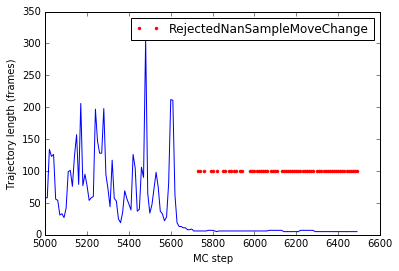

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
plt.plot(np.arange(5000,6500,10), [len(step.active[0].trajectory) for step in storage.steps[5000:6500:10]])
plt.plot(hasnan, [100]*len(hasnan), 'r.', label='RejectedNanSampleMoveChange')
plt.xlabel("MC step")
plt.ylabel("Trajectory length (frames)")
plt.legend()

In [41]:
from openpathsampling.movechange import RejectedNaNSampleMoveChange
isinstance(step.change.subchange.subchange.subchange.subchange, openpathsampling.movechange.RejectedNaNSampleMoveChange)

True

In [46]:
vis = paths.LiveVisualization(network, phi, psi, [-3.14, 3.14], [-3.14, 3.14])

In [ ]:
import time
for step in storage.steps[5500:6000]:
    print step.mccycle
    vis.draw_ipynb(step)
    time.sleep(0.1)

In [51]:
trials = [step.change.trials[0].trajectory for step in storage.steps[1::100]]

In [59]:
avg_ke = []
for i in range(len(trials)):
    t = trials[i]
    if i % 5 == 0:
        print i, "/", len(trials)
    tot_ke = 0.0
    for s in t:
        engine.current_snapshot = s
        state = engine.simulation.context.getState(getEnergy=True)
        ke = state.getKineticEnergy()
        tot_ke = ke / ke.unit
    avg_ke.append(tot_ke / len(t))


0 / 100
5 / 100
10 / 100
15 / 100
20 / 100
25 / 100
30 / 100
35 / 100
40 / 100
45 / 100
50 / 100
55 / 100
60 / 100
65 / 100
70 / 100
75 / 100
80 / 100
85 / 100
90 / 100
95 / 100


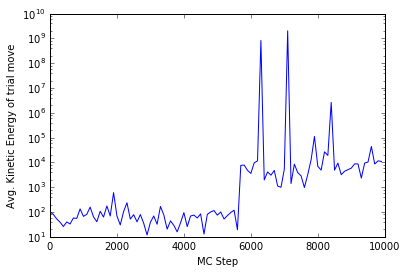

In [68]:

plt.plot(np.arange(1, 10001, 100), avg_ke)
plt.yscale("log")
plt.ylabel("Avg. Kinetic Energy of trial move")
plt.xlabel("MC Step")